<a href="https://colab.research.google.com/github/caporras2288/Curso_ML_NLP202322/blob/main/S2TC1_RandomForests_Boosting_Grupo10_202312.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,0,0,0,1,0,0,0
11,13995,2014,39972,0,0,0,0,1,0,0
167,17941,2016,18989,0,0,0,0,0,1,0
225,12493,2014,51330,0,0,0,1,0,0,0
270,7994,2007,116065,0,1,0,0,0,0,0


In [ ]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [ ]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [ ]:
# Celda 1
# Definición de la función que calcula el MSE
def mse(y):
    if y.shape[0] == 0:
        return 0
    else:
        return np.mean((y - y.mean())**2)

def mse_reduction(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    mse_y = mse(y)
    mse_l = mse(y_l)
    mse_r = mse(y_r)
    
    mse_reduction_ = mse_y - (n_l / (n_l + n_r) * mse_l + n_r / (n_l + n_r) * mse_r)
      
    return mse_reduction_

# Definición de la función best_split para calcular cuál es la mejor variable y punto de corte para hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, reduction
    
    # Para todas las variables 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            reduction = mse_reduction(X.iloc[:, j], y, split)
                        
            if reduction > best_split[2]:
                best_split = [j, split, reduction]
    
    return best_split
    
# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=6, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = y.mean()
    
    tree = dict(y_pred=y_pred, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [ ]:
tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=4, num_pct=10)

In [ ]:
def tree_predict(X, tree):
    
    predicted = np.zeros(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        predicted = predicted + tree['y_pred']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])

    return predicted

In [ ]:
y_pred = tree_predict(X_test, tree)

In [ ]:
rmsetree = np.sqrt(mean_squared_error(y_test, y_pred))
maetree = mean_absolute_error(y_test, y_pred)
print("RMSE: ", rmsetree)
print("MAE: ", maetree)

RMSE:  1782.6888801629282
MAE:  1345.3253795686473


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de clasificación y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 2
# Se divide el dataframe data manualmente en test y train con el 33% para test.
print(len(data))
print(len(X_train))
print(len(X_test))
print(len(X_train)+len(X_test))

10495
7031
3464
10495


In [ ]:
# Se divide el dataframe data manualmente en test y train con el 33% para test.
train = data.iloc[:7031, :]
test = data.iloc[7031:, :]
print(len(train))
print(len(test))
print(len(train)+len(test))
print(len(data))

7031
3464
10495
10495


In [ ]:
# Se crea un arreglo de el 90% del total de los datos
import numpy as np
Bootstrap = round(len(data) * 0.9)
Bootstrap

9446

In [ ]:
# Se crea un arreglo de 1 a 9446
np.random.seed(1)

# Impresión de arreglo y muestreo aleatorio
nums = np.arange(1, Bootstrap+1)
print('Arreglo:', nums)
print('Muestreo aleatorio: ', np.random.choice(a=nums, size=9446, replace=True))

Arreglo: [   1    2    3 ... 9444 9445 9446]
Muestreo aleatorio:  [ 236 5193  906 ... 5538 7220  653]


In [ ]:
# Creación de 10 muestras de bootstrap 
np.random.seed(123)

n_samples = train.shape[0]
n_B = 10

samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
samples

[array([3582, 3454, 1346, ...,  826,  801, 5657]),
 array([6962, 3408, 2553, ..., 6611,  877, 6412]),
 array([1917, 3131,  384, ..., 2876, 6449, 6557]),
 array([3849, 4565, 6820, ..., 6835, 4643,  639]),
 array([2468, 3608, 1367, ..., 3108, 2961, 4357]),
 array([3142, 1537, 5966, ..., 3224, 6922, 3396]),
 array([6588, 3753, 1786, ..., 2131, 4627, 5672]),
 array([1289, 3776,  981, ..., 1891, 6034, 6165]),
 array([6079, 3819, 6976, ..., 6478, 2225, 5072]),
 array([3952, 3276,  896, ..., 4589, 1964,  893])]

In [ ]:
#Muestra boostrap 1
samples[0]

array([3582, 3454, 1346, ...,  826,  801, 5657])

In [ ]:
# Visualización muestra boostrap #1 para entremiento
train.iloc[samples[0], :]

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
137130,8995,2010,88909,0,0,0,0,1,0,0
132538,5998,2007,136022,0,0,0,0,1,0,0
51669,16500,2015,27217,0,0,0,0,0,1,0
154900,17508,2017,34279,0,0,0,0,0,1,0
199443,13695,2012,77117,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
10241,10790,2011,90375,0,0,0,0,1,0,0
4214,8995,2009,62991,0,1,0,0,0,0,0
32299,11988,2011,76862,0,0,0,0,1,0,0
31240,19248,2017,32465,0,0,0,0,0,1,0


In [ ]:
# Construcción un árbol de decisión para cada muestra boostrap con regresion

from sklearn.tree import DecisionTreeRegressor

# Definición del modelo usando DecisionTreeRegressor de sklearn
treereg = DecisionTreeRegressor(max_depth=None, random_state=123)

# DataFrame para guardar las predicciones de cada árbol
y_pred = pd.DataFrame(index=test.index, columns=[list(range(n_B))])

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    X_train_2 = train.iloc[sample, 1:]
    y_train_2 = train.iloc[sample, 0]
    treereg.fit(X_train_2, y_train_2)
    y_pred.iloc[:,i] = treereg.predict(X_test)
    
y_pred

,0,1,2,3,4,5,6,7,8,9
266476,9900.0,9900.0,9900.0,9900.0,9900.0,11995.0,11788.0,9900.0,9900.0,9900.0
266526,5995.0,7495.0,5995.0,7495.0,5995.0,5995.0,6987.0,6700.0,7495.0,6492.0
266544,15814.0,15814.0,15814.0,15814.0,16491.0,15814.0,15814.0,15349.0,15814.0,15349.0
266552,17997.0,16691.0,15813.0,17997.0,17997.0,17997.0,17997.0,21990.0,23482.0,23482.0
266617,18995.0,18995.0,16951.0,16951.0,16951.0,16951.0,18995.0,15988.0,18995.0,18995.0
...,...,...,...,...,...,...,...,...,...,...
399845,15976.0,17988.0,15976.0,17988.0,17988.0,16977.0,15976.0,17988.0,15976.0,17988.0
399928,14699.0,14699.0,15700.0,16900.0,15700.0,15999.0,14995.0,14851.0,14851.0,14851.0
399934,18330.0,17803.0,18330.0,23533.0,18330.0,23533.0,18330.0,23533.0,18330.0,18330.0
399951,10495.0,10495.0,12989.0,12989.0,10495.0,10495.0,12989.0,10495.0,12995.0,10495.0


In [ ]:
# Desempeño de cada árbol
from sklearn.metrics import mean_squared_error
for i in range(n_B):
    print('Árbol ', i, 'tiene un error: ', np.sqrt(mean_squared_error(y_pred.iloc[:,i], y_test)))

Árbol  0 tiene un error:  1660.1411726141453
Árbol  1 tiene un error:  1624.2014889152688
Árbol  2 tiene un error:  1619.3033008294965
Árbol  3 tiene un error:  1661.0335050691997
Árbol  4 tiene un error:  1642.5555994451854
Árbol  5 tiene un error:  1630.948425578028
Árbol  6 tiene un error:  1663.1370581249548
Árbol  7 tiene un error:  1651.6951167490276
Árbol  8 tiene un error:  1659.3293244606423
Árbol  9 tiene un error:  1635.898227033642


In [ ]:
# Predicciones promedio para cada obserbación del set de test
y_pred.mean(axis=1)

266476    10298.3
266526     6664.4
266544    15788.7
266552    19144.3
266617    17876.7
           ...   
399845    17082.1
399928    15324.5
399934    19838.2
399951    11493.2
399976    12010.6
Length: 3464, dtype: float64

In [ ]:
# Error al promediar las predicciones de todos los árboles
np.sqrt(mean_squared_error(y_test, y_pred.mean(axis=1)))

1224.9754517796266

Teniendo en cuenta la métrica de desempeño del modelo **root mean_squared_error** se observa que los 10 arboles presentan errores similares, y que el que presenta el mejor error que es el árbol 2 con **1619** esta por debajo del desempeño de los modelos combinados con un error de **1224** lo que ratifica el mejor desempeño del ensamblaje.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de clasificación y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 3
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

7031
3464
7031
3464


In [ ]:
# Se define log_n_features como el logaritmo natural del total de las variables predictoras rendondeadas.
import math
log_n_features = int(math.log(len(X_train.columns)))
log_n_features 

2

In [ ]:
# Uso de BaggingRegressor de la libreria (sklearn) donde se usa el modelo DecisionTreeRegressor como estimador y max_features= log_n_features
from sklearn.ensemble import BaggingRegressor
bagreg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=10, max_features= log_n_features,
                          bootstrap=True, oob_score=True, random_state=1)

In [ ]:
# Entrenemiento del modelo con set de entrenamiento y predicción en el set de test
bagreg.fit(X_train, y_train)
y_pred = bagreg.predict(X_test)
y_pred

array([14053.03558458, 11243.53959462, 14920.88654487, ...,
       15850.81283632, 13181.6624878 , 13592.438716  ])

In [ ]:
# Cálculo del error del modelo
np.sqrt(mean_squared_error(y_test, y_pred))

2671.0127988157697

Siendo P el número de variables predictoras del modelo y teniendo en cuenta que este es un problema de regresión el parámetro **max_features** debería estar entre P/3 y P, como en este caso se contemplo igual a log(n_features) presenta un error mayor (**2671**) que teniendo en cuenta todas las variables predictoras como se observó en el modelo de bagging manual igual a (**1224**), esto quiere decir que para este caso el desempeño del modelo desmejoro.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 4
# Definición de modelo Random Forest para un problema de clasificación
clf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)

# Ajustar el modelo en los datos de entrenamiento
clf.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = clf.predict(X_test)

# Cálculo MSE y MAE
rmserf = np.sqrt(mean_squared_error(y_test, y_pred))
maerf = mean_absolute_error(y_test, y_pred)
print("RMSE: ", rmserf)
print("MAE: ", maerf)


RMSE:  1618.3981767912924
MAE:  1200.3937072243482


Se estima el modelo random forest con 100 árboles y con una profundida máxima de 5. Si se compara el RMSE y MAE frente al árbol de decision vemos que random forest tiene un mayor poder predictivo pues sus valores son menores. Esto se debe a que se utilizan varios árboles con remuestreo aleatorio consiguiendo una mayor precisión y estabilidad, de igual manera se reduce la varianza. Sin embargo, es importante realizar una calibración de los parámetros ya que esto podria mejor la precisión del modelo. 

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para clasificación, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

El N_estimators que minimiza el MAE es de  61


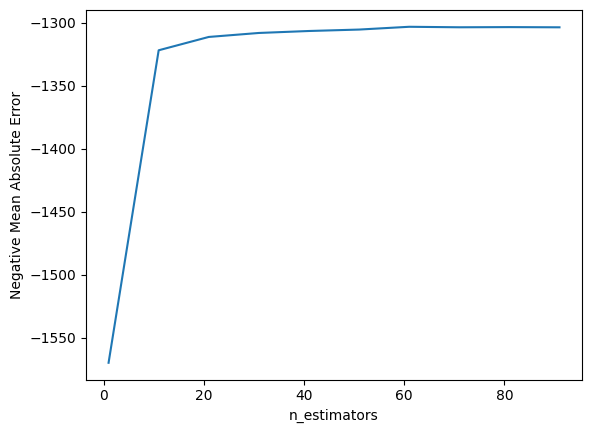

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
# Calibración n_estimators
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range_nestimators = range(1,100,10)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores_nestimators = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range_nestimators:
    clf = RandomForestRegressor(n_estimators=estimator, random_state=1)
    accuracy_scores_nestimators.append(cross_val_score(clf, X, y, cv=5, scoring = 'neg_mean_absolute_error').mean())

plt.plot(estimator_range_nestimators, accuracy_scores_nestimators)
plt.xlabel('n_estimators')
plt.ylabel('Negative Mean Absolute Error')
print('El N_estimators que minimiza el MAE es de  '+str(estimator_range_nestimators[accuracy_scores_nestimators.index(max(accuracy_scores_nestimators))]))


El max_depth que minimiza el MAE es de  8


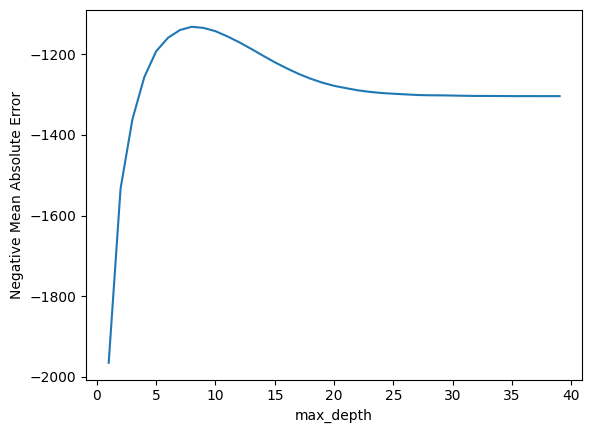

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
# Calibración max_depth
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
depth_range_nestimators = range(1,40)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores_depth = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in depth_range_nestimators:
    clf = RandomForestRegressor(max_depth=estimator, random_state=1)
    accuracy_scores_depth.append(cross_val_score(clf, X, y, cv=5, scoring = 'neg_mean_absolute_error').mean())

plt.plot(depth_range_nestimators, accuracy_scores_depth)
plt.xlabel('max_depth')
plt.ylabel('Negative Mean Absolute Error')
print('El max_depth que minimiza el MAE es de  '+str(accuracy_scores_depth.index(max(accuracy_scores_depth))+1))

El max_features que minimiza el MAE es de  9


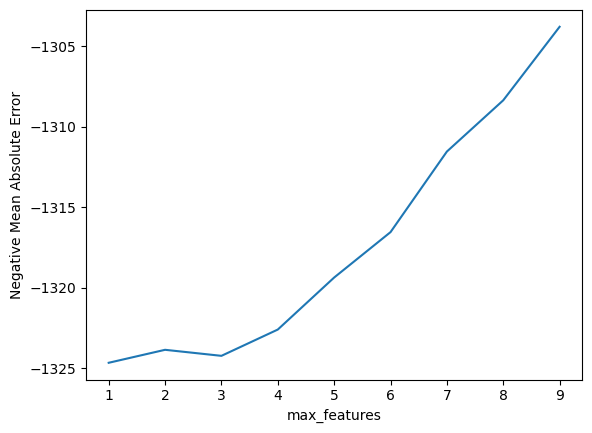

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
# Calibración max_features
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
features_range_nestimators = range(1,10)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
accuracy_scores_features = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in features_range_nestimators:
    clf = RandomForestRegressor(max_features=estimator, random_state=1)
    accuracy_scores_features.append(cross_val_score(clf, X, y, cv=5, scoring = 'neg_mean_absolute_error').mean())

plt.plot(features_range_nestimators, accuracy_scores_features)
plt.xlabel('max_features')
plt.ylabel('Negative Mean Absolute Error')
print('El max_features que minimiza el MAE es de  '+str(features_range_nestimators[accuracy_scores_features.index(max(accuracy_scores_features))]))

In [ ]:
from sklearn.metrics import explained_variance_score
# Definición de modelo Random Forest para un problema de clasificación
clf_cal = RandomForestRegressor(n_estimators=61, max_depth=8, max_features = 9, random_state=42)

# Ajustar el modelo en los datos de entrenamiento
clf_cal.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred_cal = clf_cal.predict(X_test)

# Cálculo MSE y MAE
rmserf_cal = np.sqrt(mean_squared_error(y_test, y_pred_cal))
maerf_cal = mean_absolute_error(y_test, y_pred_cal)
everf_cal = explained_variance_score(y_test, y_pred_cal)
print("Explained Variance Score: ", everf_cal)
print("RMSE: ", rmserf_cal)
print("MAE: ", maerf_cal)

Explained Variance Score:  0.8397864530648005
RMSE:  1565.8147223729486
MAE:  1150.676982606294


Para cada una de los parámetros a calibrar, puede observarse el siguiente desempeño al interior del modelo:

*   **n_estimators:** Conforme aumenta el número de árboles, disminuye el error del modelo. Sin embargo, se llega a un punto donde la disminución del error es mínima, y se incrementa progresivamente el tiempo de cómputo
*   **max_depth:** Conforme aumenta la profundidad máxima, disminuye el error del modelo. Sin embargo, se llega a un punto máximo y empieza a aumentar el error, cuando empieza a observarse _overfitting_
*   **max_features:** El error disminuye conforme aumenta la cantidad de variables. En este caso, al ser un número pequeño de variables, no se logra apreciar un descenso de las mismas

Finalmente, al momento de comparar los resultados del random forest calibrado vs el random forest sin calibrar, se observa un descenso significativo de las métricas de error, por lo que siempre es recomendable realizar dicha calibración para obtener el mejor modelo






### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de clasificación con la librería sklearn y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 6
from xgboost import XGBRegressor

clf_xg = XGBRegressor()
clf_xg
clf_xg.fit(X_train, y_train)
y_pred_xg = clf_xg.predict(X_test)
# Cálculo MSE y MAE
rmserf_xg = np.sqrt(mean_squared_error(y_test, y_pred_xg))
maerf_xg = mean_absolute_error(y_test, y_pred_xg)
print("RMSE: ", rmserf_xg)
print("MAE: ", maerf_xg)


RMSE:  1621.4197004256812
MAE:  1186.634392366123


Al comparar con los modelos anteriormente ejecutados, puede observarse que el XGBoost posee métricas de error similares a las del modelo de Random Forest calibrado, por lo que se puede concluir que presenta un buen desempeño, y que con una calibración apropiada puede incluso llegar a superar en rendimiento al Random Forest

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para clasificación, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

El max_features que minimiza el MAE es de  0.1


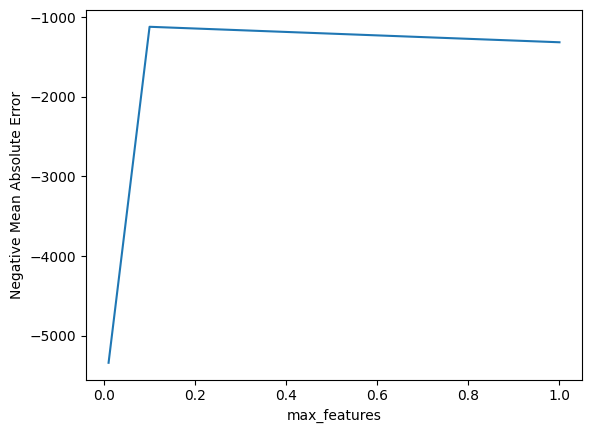

In [ ]:
import matplotlib.pyplot as plt
accuracy_scores_features = []

features_range_nestimators = [0.01, 0.1, 1]

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in features_range_nestimators:
    clf = XGBRegressor(learning_rate=estimator, random_state=1)
    accuracy_scores_features.append(cross_val_score(clf, X, y, cv=5, scoring = 'neg_mean_absolute_error').mean())

plt.plot(features_range_nestimators, accuracy_scores_features)
plt.xlabel('max_features')
plt.ylabel('Negative Mean Absolute Error')
print('El max_features que minimiza el MAE es de  '+str(features_range_nestimators[accuracy_scores_features.index(max(accuracy_scores_features))]))

El max_features que minimiza el MAE es de  0


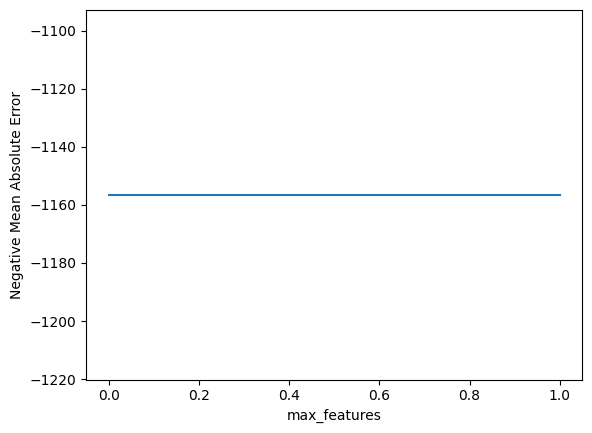

In [ ]:
import matplotlib.pyplot as plt
accuracy_scores_features = []

features_range_nestimators = [0, 0.1, 0.5, 1]

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in features_range_nestimators:
    clf = XGBRegressor(gamma=estimator, random_state=1)
    accuracy_scores_features.append(cross_val_score(clf, X, y, cv=5, scoring = 'neg_mean_absolute_error').mean())

plt.plot(features_range_nestimators, accuracy_scores_features)
plt.xlabel('max_features')
plt.ylabel('Negative Mean Absolute Error')
print('El max_features que minimiza el MAE es de  '+str(features_range_nestimators[accuracy_scores_features.index(max(accuracy_scores_features))]))

El max_features que minimiza el MAE es de  0.5


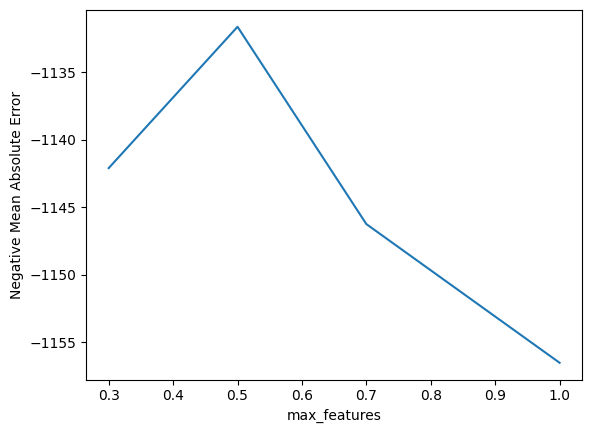

In [ ]:
import matplotlib.pyplot as plt
accuracy_scores_features = []

features_range_nestimators = [0.3, 0.5, 0.7, 1]

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in features_range_nestimators:
    clf = XGBRegressor(colsample_bytree=estimator, random_state=1)
    accuracy_scores_features.append(cross_val_score(clf, X, y, cv=5, scoring = 'neg_mean_absolute_error').mean())

plt.plot(features_range_nestimators, accuracy_scores_features)
plt.xlabel('max_features')
plt.ylabel('Negative Mean Absolute Error')
print('El max_features que minimiza el MAE es de  '+str(features_range_nestimators[accuracy_scores_features.index(max(accuracy_scores_features))]))

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Definir los parámetros para el modelo XGBoost
parametros = {
    'learning_rate': [0.01, 0.1, 1],
    'gamma': [0, 0.1, 0.5, 1],
    'colsample_bytree': [0.3, 0.5, 0.7, 1]
}

# Crear el modelo XGBoost
xgb_reg = XGBRegressor()

# Usar GridSearchCV para buscar los mejores parámetros
busqueda = GridSearchCV(xgb_reg, parametros, scoring='explained_variance', cv=5, verbose=3)

# Ajustar el modelo a los datos de entrenamiento
busqueda.fit(X_train, y_train)

# Imprimir los mejores parámetros y puntajes de la búsqueda
print("Mejores parámetros: ", busqueda.best_params_)
print("Mejor puntaje: ", busqueda.best_score_)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01;, score=0.487 total time=   0.2s
[CV 2/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01;, score=0.505 total time=   0.2s
[CV 3/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01;, score=0.510 total time=   0.2s
[CV 4/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01;, score=0.508 total time=   0.3s
[CV 5/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.01;, score=0.500 total time=   2.0s
[CV 1/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.1;, score=0.833 total time=   0.2s
[CV 2/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.1;, score=0.838 total time=   0.2s
[CV 3/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.1;, score=0.855 total time=   0.2s
[CV 4/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.1;, score=0.869 total time=   0.2s
[CV 5/5] END colsample_bytree=0.3, gamma=0, learning_rate=0.1;, score=0.829 to

In [ ]:
# Entrenamiento (fit) y desempeño del modelo XGBClassifier
from sklearn.metrics import explained_variance_score
xgb_reg = XGBRegressor(colsample_bytree = 0.7, gamma= 0, learning_rate= 0.1)
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_test)
print("Explained Variance Score: ",(explained_variance_score(y_pred, y_test)))

rmserf_xg2 = np.sqrt(mean_squared_error(y_test, y_pred))
maerf_xg2 = mean_absolute_error(y_test, y_pred)
print("RMSE: ", rmserf_xg2)
print("MAE: ", maerf_xg2)

Explained Variance Score:  0.8142892507794715
RMSE:  1548.817634900055
MAE:  1136.4953260884274


*   La variación de colsample_bytree parece tener un impacto más grande en el puntaje que la variación de gamma y learning_rate.
*   Para valores bajos de learning_rate y colsample_bytree (0.01 y 0.3, respectivamente), el puntaje del modelo es bajo, pero el tiempo de ejecución es bajo.
*   A medida que aumenta el valor de learning_rate, el puntaje del modelo mejora significativamente, pero el tiempo de ejecución sigue siendo bajo.
*   Para valores más altos de colsample_bytree (0.5 y 0.7), el puntaje del modelo mejora en general, pero el tiempo de ejecución aumenta.
*   En general, el puntaje del modelo es más alto para valores más altos de learning_rate, colsample_bytree, mientras que el tiempo de ejecución es más alto para valores más bajos de learning_rate y colsample_bytree.
*   Los mejores parametros obtenidos para el modelo corresponden a {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.1}

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

Teniendo en cunta los resultados obtenidos: 

XGBoost regressor:

*   Explained Variance Score:  0.8142892507794715
*   Root Mean Squared Error:  1548.817634900055
*   Mean Absolute Error:  1136.4953260884274

Random Forest: 

* Explained Variance Score:  0.8397864530648005
* Root Mean Squared Error:  1565.8147223729486
* Mean Absolute Error:  1150.676982606294

Ambos modelos, el XGBoost Regressor y el random forest, parecen tener un buen desempeño, ya que el Explained Variance Score (EVS) es mayor a 0.8, lo que significa que la mayoría de la varianza en los datos de prueba está siendo explicada por los modelos. Además, ambos modelos tienen un Root Mean Squared Error (RMSE) y Mean Absolute Error (MAE) relativamente bajos, lo que indica que los modelos están haciendo predicciones precisas.

Sin embargo, el modelo de XGBoost Regressor parece tener un rendimiento ligeramente mejor que el modelo random forest, ya que tiene un RMSE y un MAE ligeramente más bajos. Sin embargo, la diferencia entre los resultados de los dos modelos no es muy grande, por lo que se podría considerar que ambos modelos tienen un rendimiento similar.


**Ventajas mejor modelo XGBoost Regressor**
* XGBoost utiliza técnicas avanzadas de optimización y regularización para reducir la varianza, haciendo que la predicción sea más estable. Otra mejora algorítmica es que aprende el mejor valor para los missing values según la pérdida de entrenamiento. 

**Desventajas peor modelo Random Forest**
* Es propenso a sobreajuste: Un modelo de Random Forest puede ser propenso al sobreajuste sobretodo en muestras pequeñas con variables altamente correlacionadas. Así mismo, no es tan bueno como XGBoost en el manejo de missing values.